In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data_path = './'
img_idx = '00002'
rgb_name = data_path + img_idx+'_rgb.jpg'
landmark_name = data_path + img_idx+'_2d.npy'
depth_name = data_path + img_idx+'_depth.npy'
pose_name = data_path + img_idx+'_pose.npy'
cam_mat_name = data_path + img_idx+'_cam_mat.npy'

In [7]:
import cv2

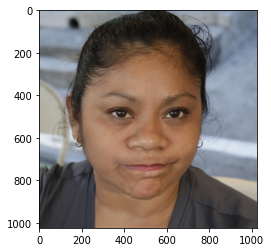

In [8]:
bgr = cv2.imread(rgb_name)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

depth raw shape:  (1024, 1024, 3)


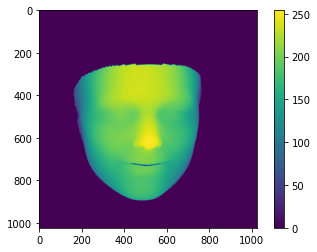

In [9]:
depth_raw = np.load(depth_name) # Dpeth value is mapped to the interval [0:255]
print('depth raw shape: ', depth_raw.shape)
depth_slice = depth_raw[:,:,0]
plt.imshow(depth_slice)
plt.colorbar()
plt.show()

landmark raw shape:  (3, 68)


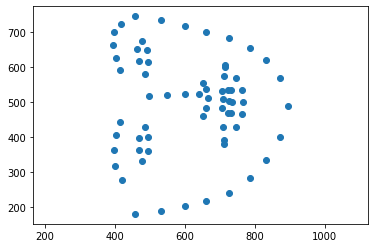

In [10]:
landmark_raw = np.load(landmark_name)
print('landmark raw shape: ', landmark_raw.shape)

plt.scatter(landmark_raw[1, :], landmark_raw[0, :])
plt.axis('equal')
plt.show()

In [11]:
left_eyebrow = np.hstack((landmark_raw[0, 17:22][:, np.newaxis], landmark_raw[1, 17:22][:, np.newaxis]))
print('Shpae of left eyebrow: ', left_eyebrow.shape)

right_eyebrow = np.hstack((landmark_raw[0, 22:27][:, np.newaxis], landmark_raw[1, 22:27][:, np.newaxis]))
print('Shpae of right eyebrow: ', right_eyebrow.shape)

left_eye = np.hstack((landmark_raw[0, 36:42][:, np.newaxis], landmark_raw[1, 36:42][:, np.newaxis]))
print('Shpae of left eye: ', left_eye.shape)

right_eye = np.hstack((landmark_raw[0, 42:48][:, np.newaxis], landmark_raw[1, 42:48][:, np.newaxis]))
print('Shpae of right eye: ', right_eye.shape)

mouth = np.hstack((landmark_raw[0, 48:68][:, np.newaxis], landmark_raw[1, 48:68][:, np.newaxis]))
print('Shpae of mouth: ', mouth.shape)

left = np.vstack((left_eyebrow, left_eye))
print('Shape of left part: ', left.shape)

right = np.vstack((right_eyebrow, right_eye))
print('Shape of right part: ', right.shape)

left_u_max = int(np.max(left[:, 0]))
left_u_min = int(np.min(left[:, 0]))
left_v_max = int(np.max(left[:, 1]))
left_v_min = int(np.min(left[:, 1]))
print('Left u max: ', left_u_max)
print('Left u min: ', left_u_min)
print('Left v max: ', left_v_max)
print('Left v min: ', left_v_min)

right_u_max = int(np.max(right[:, 0]))
right_u_min = int(np.min(right[:, 0]))
right_v_max = int(np.max(right[:, 1]))
right_v_min = int(np.min(right[:, 1]))
print('Right u max: ', right_u_max)
print('Right u min: ', right_u_min)
print('Right v max: ', right_v_max)
print('Right v min: ', right_v_min)

mouth_u_max = int(np.max(mouth[:, 0]))
mouth_u_min = int(np.min(mouth[:, 0]))
mouth_v_max = int(np.max(mouth[:, 1]))
mouth_v_min = int(np.min(mouth[:, 1]))
print('Mouth u max: ', mouth_u_max)
print('Mouth u min: ', mouth_u_min)
print('Mouth v max: ', mouth_v_max)
print('Mouth v min: ', mouth_v_min)

Shpae of left eyebrow:  (5, 2)
Shpae of right eyebrow:  (5, 2)
Shpae of left eye:  (6, 2)
Shpae of right eye:  (6, 2)
Shpae of mouth:  (20, 2)
Shape of left part:  (11, 2)
Shape of right part:  (11, 2)
Left u max:  442
Left u min:  277
Left v max:  494
Left v min:  398
Right u max:  724
Right u min:  581
Right v max:  493
Right v min:  395
Mouth u max:  605
Mouth u min:  380
Mouth v max:  766
Mouth v min:  705


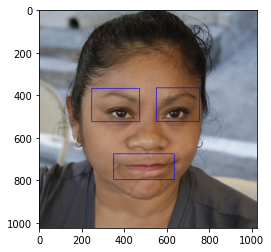

In [12]:
delta = 30
from copy import deepcopy

new_rgb = deepcopy(rgb)
cv2.rectangle(new_rgb, (left_u_min-delta, left_v_min-delta), (left_u_max+delta, left_v_max+delta), (0,0,255), 2)
cv2.rectangle(new_rgb, (right_u_min-delta, right_v_min-delta), (right_u_max+delta, right_v_max+delta), (0,0,255), 2)
cv2.rectangle(new_rgb, (mouth_u_min-delta, mouth_v_min-delta), (mouth_u_max+delta, mouth_v_max+delta), (0,0,255), 2)
plt.imshow(new_rgb)
plt.show()

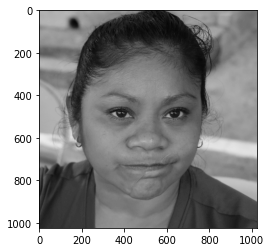

In [13]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()

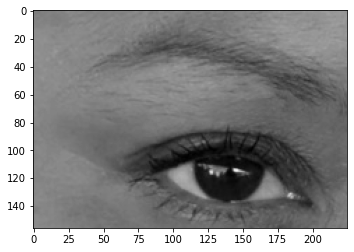

In [14]:
gray_left = gray[left_v_min-delta:left_v_max+delta, left_u_min-delta:left_u_max+delta]
plt.imshow(gray_left, cmap=plt.get_cmap('gray'))
plt.show()

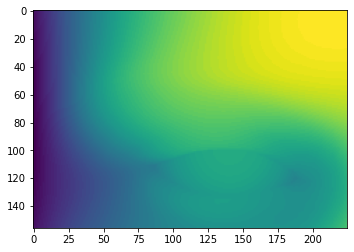

In [15]:
depth_left = depth_slice[left_v_min-delta:left_v_max+delta, left_u_min-delta:left_u_max+delta]
plt.imshow(depth_left)
# plt.colorbar()
plt.show()

In [95]:
import torch.nn as nn
import torch

class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width, projection_type):
        super(BackprojectDepth, self).__init__()

        self.batch_size = 1
        self.height = height
        self.width = width
        self.projection_type = projection_type

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        if self.projection_type=='perspective':
            cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
            cam_points = depth.view(self.batch_size, 1, -1) * cam_points
            cam_points = torch.cat([cam_points, self.ones], 1)
        elif self.projection_type=='orthographic':
            new_pix_coords = self.pix_coords[:, :2, :] # Extract the x and y coordinates of all pixels
            cam_points = torch.cat([new_pix_coords, depth.view(self.batch_size, 1, -1)], 1) # Append the flattened depth values to x and y
            cam_points = torch.cat([cam_points, self.ones], 1) # Append additional ones to the last dimension
        else:
            raise NotImplementedError(f'Not yet supported for projection type {self.projection_type}.')
                    
        return cam_points

class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, projection_type, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.projection_type = projection_type
        self.eps = eps

    def forward(self, points, K, T):
        """
        Here the input points are from the BackprojectDepth
        """
        if self.projection_type=='perspective':
            P = torch.matmul(K, T)[:, :3, :]
            cam_points = torch.matmul(P, points)            
            pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
            pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
            pix_coords = pix_coords.permute(0, 2, 3, 1)
            pix_coords[..., 0] /= self.width - 1
            pix_coords[..., 1] /= self.height - 1
            pix_coords = (pix_coords - 0.5) * 2
        elif self.projection_type=='orthographic':
            new_T = T[:, :3, :]
            
            cam_points = torch.matmul(new_T, points)

            # pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
            pix_coords = cam_points[:,:2,:] # orthographic does not need normalization
            
            pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
            pix_coords = pix_coords.permute(0, 2, 3, 1)

            pix_coords[..., 0] /= self.width - 1
            pix_coords[..., 1] /= self.height - 1
            
            pix_coords = (pix_coords - 0.5) * 2
        else:
            raise NotImplementedError(f'Not yet supported for the projection type {self.projection_type}.')
        return pix_coords

def image_warping(K, R, t, gray_img, depth_img, projection_type):
    """
    depth_img: [0, 255]
    """
    additional_row = np.array([0.0, 0.0, 0.0, 1.0])

    temp_T = np.hstack((R, t[:, np.newaxis]))
    T = np.vstack((temp_T, additional_row[np.newaxis, :]))
    
    print('Transformation matrix: ', T)
    
    inv_K = np.linalg.pinv(K)    
    normalized_depth = depth_img / 255.
    h, w = gray_img.shape
    batch_size = 1
    
    backproject_depth = BackprojectDepth(batch_size, h, w, projection_type)
    project_3d = Project3D(batch_size, h, w, projection_type)
    
    temp_normalized_depth = deepcopy(normalized_depth)
    new_normalized_depth = np.expand_dims(temp_normalized_depth, axis=0)
    new_normalized_depth_np = np.expand_dims(new_normalized_depth, axis=0)
    new_normalized_depth = torch.tensor(new_normalized_depth_np).float()

    temp_K = deepcopy(K)
    new_K_np = np.expand_dims(temp_K, axis=0)
    new_K = torch.tensor(new_K_np).float()

    temp_T = deepcopy(T)
    new_T_np = np.expand_dims(temp_T, axis=0)
    new_T = torch.tensor(new_T_np).float()

    temp_inv_K = deepcopy(inv_K)
    new_inv_K_np = np.expand_dims(temp_inv_K, axis=0)
    new_inv_K = torch.tensor(new_inv_K_np).float()

    cam_points = backproject_depth(new_normalized_depth, new_inv_K)
    pix_coords = project_3d(cam_points, new_K, new_T)

    import torch.nn.functional as F
    temp_gray = deepcopy(gray_img)
    new_gray_np = np.expand_dims(temp_gray, axis=0)
    new_gray_np = np.expand_dims(new_gray_np, axis=0)
    new_gray = torch.tensor(new_gray_np).float()

    warped_gray = F.grid_sample(new_gray, pix_coords, mode='bilinear', padding_mode='zeros')
    
    plt.imshow(gray_img, cmap=plt.get_cmap('gray'))
    plt.show()
    plt.imshow(np.squeeze(warped_gray), cmap=plt.get_cmap('gray'))
    plt.show()

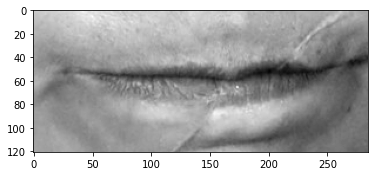

In [17]:
gray_mouth = gray[mouth_v_min-delta:mouth_v_max+delta, mouth_u_min-delta:mouth_u_max+delta]
plt.imshow(gray_mouth, cmap=plt.get_cmap('gray'))
plt.show()

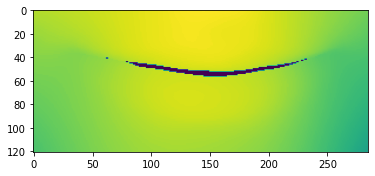

In [18]:
depth_mouth = depth_slice[mouth_v_min-delta:mouth_v_max+delta, mouth_u_min-delta:mouth_u_max+delta]
plt.imshow(depth_mouth)
# plt.colorbar()
plt.show()

Transformation matrix:  [[ 4.924e-01  2.760e-01  8.254e-01  0.000e+00]
 [ 8.680e-02  9.280e-01 -3.600e-01  1.024e+02]
 [-8.660e-01  2.500e-01  4.330e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


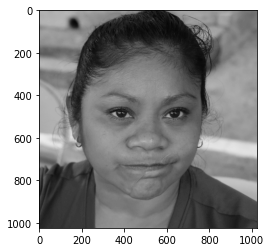

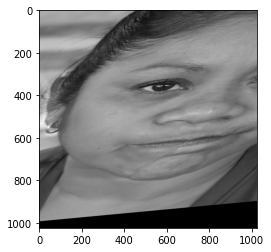

In [126]:
# R = np.array([[0.99,  0.0, 0.03], # pitch=2deg
#                [0.0,  1.0,  0.0],
#                [-0.03, 0,  0.99]])

# R = np.array([[0.99,  0.0, -0.06], # pitch=4deg
#                [0.0,  1.0,  0.0],
#                [0.06, 0,  0.99]])

# R = np.array([[0.99,  0.0, 0.13], # pitch=8deg
#                [0.0,  1.0,  0.0],
#                [-0.13, 0,  0.99]])

# R = np.array([[0.96,  0.0, 0.25], # pitch=15deg
#                [0.0,  1.0,  0.0],
#                [-0.25, 0,  0.96]])

# R = np.array([[0.86,  0.0, 0.49], # pitch=30deg
#                [0.0,  1.0,  0.0],
#                [-0.5, 0,  0.86]])

# R = np.array([[0.86,  -0.5, 0.], # yaw=30deg
#                [0.49,  0.86,  0.0],
#                [0., 0,  1.0]])

# R = np.array([[0.99,  0., 0.], # roll=30deg
#                [0.,  0.99,  -0.],
#                [-0.0, 0.0,  0.99]])

# R = np.array([[0.97,  -0.13, -0.17], # pitch=-10, yaw=8
#                [0.13,  0.99,  -0.02],
#                [0.17, 0.0,  0.98]])

# R = np.array([[0.95,  -0.17, 0.25], # pitch=15, yaw=10
#                [0.17,  0.98,  0.04],
#                [-0.25, 0.0,  0.96]])

# R = np.array([[0.1736,  0.3368, 0.9254], # pitch=20deg, yaw=80deg
#                [0.,  0.9396,  -0.342],
#                [-0.98, 0.0593,  0.1631]])

# R = np.array([[0.5,  0.433, 0.75], # pitch=30deg, yaw=60deg
#                [0.,  0.866,  -0.5],
#                [-0.866, 0.25,  0.433]])

# R = np.array([[1.0,  0., 0.], 
#                [0.,  1.,  0.],
#                [0., 0.,  1.]])

"""
Note: t values have to be enlarged by the size of the image
Otherwise, the translation will be ignored because the value is too small compared with the image size (1024). 
The pix_coords is normalized by the image size before sent to the grid sampler

z value in t has no role in orthographic projection because the z component is droped when projecting back from 3D to 2D
"""

# t = np.array([0, 0, 0]) # horizontal, vertical, z axis

K = np.array([[371.2, 0.0, 512.0, 0.0],
              [0.0, 368.64, 512.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])

proj_type = 1
if proj_type == 0:
    R = np.array([[0.9848,  0.0449, 0.1677], # pitch=15, yaw=10, 
                   [0.,  0.96,  -0.25],
                   [-0.17, 0.2548,  0.9512]])
    t = np.array([0., 0., 0])
    projection_type = 'perspective'
elif proj_type == 1:
    R = np.array([[0.4924,  0.276, 0.8254], # pitch=30deg, yaw=60deg, roll=10deg
               [0.0868,  0.928,  -0.36],
               [-0.866, 0.25,  0.433]])
    
    t = 1024*np.array([0., 0.1, 0]) # horizontal, vertical, z axis
    
    projection_type = 'orthographic'
    
image_warping(K, R, t, gray, depth_slice, projection_type)

src pts:  [[277. 398.]
 [277. 494.]
 [442. 494.]
 [442. 398.]]
dst pts:  [[297. 398.]
 [257. 474.]
 [462. 474.]
 [422. 418.]]


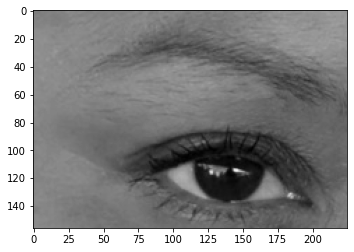

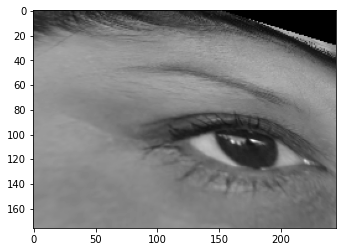

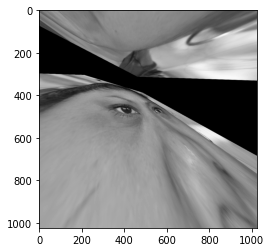

In [119]:
dd = 20
src_pts = np.array([[left_u_min, left_v_min], [left_u_min, left_v_max], [left_u_max, left_v_max], [left_u_max, left_v_min]], dtype=np.float32)
print('src pts: ', src_pts)

# dst_pts = np.array([[left_u_min+dd, left_v_min-dd], [left_u_min+dd, left_v_max+dd], [left_u_max+dd, left_v_max-dd], [left_u_max+dd, left_v_min+dd]], dtype=np.float32)
dst_pts = np.array([[left_u_min+dd, left_v_min], [left_u_min-dd, left_v_max-dd], [left_u_max+dd, left_v_max-dd], [left_u_max-dd, left_v_min+dd]], dtype=np.float32)
print('dst pts: ', dst_pts)

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(gray, M, (1024, 1024))

gray_left = gray[left_v_min-delta:left_v_max+delta, left_u_min-delta:left_u_max+delta]
plt.imshow(gray_left, cmap=plt.get_cmap('gray'))
plt.show()

newnew = warp[left_v_min-2*dd:left_v_max+2*dd, left_u_min-2*dd:left_u_max+2*dd]
plt.imshow(newnew, cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(warp, cmap=plt.get_cmap('gray'))
plt.show()